In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from tyssue.generation import generate_ring
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec

from tyssue_taylor.adjusters.adjust_annular import prepare_tensions, adjust_parameters
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, opt_sum_lambda
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Using TensorFlow backend.


#### Initialisation d'un maillage régulier 

Reseting datasets values with new specs


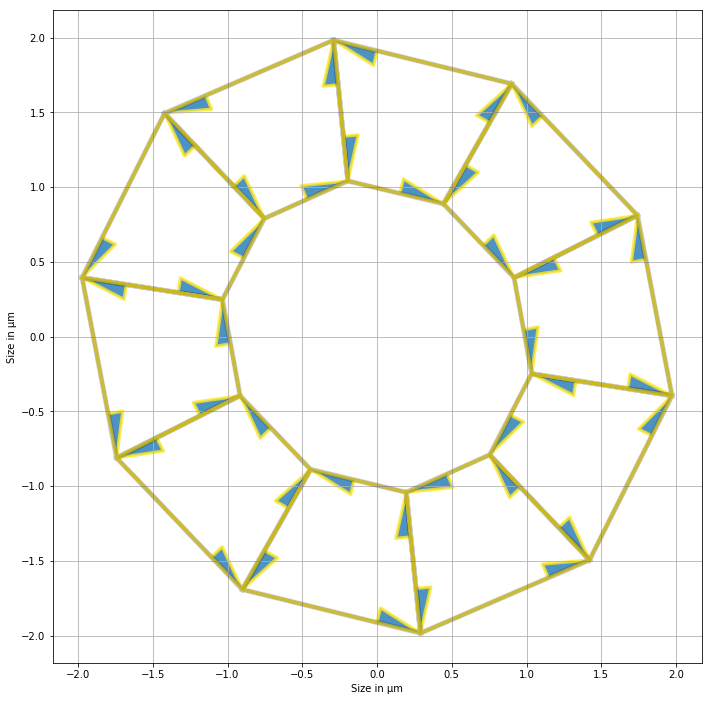

In [2]:
nf, r_in, r_out = (10, 1, 2)
seed = 1
organo = create_organo(nf, r_in, r_out, rot=np.pi/12)

geom.update_all(organo)
Solver.find_energy_min(organo, geom, model)
print_tensions(organo, organo)

### Estimation de la somme des tensions

Dans un premier temps on calcule la somme des tensions optimale avec la fonction opt_sum_lambda du module adjusters.force_inference. Cette fonction lance une procédure d'optimisation de scipy.optimize.minimize_scalar et prend comme paramètres:

- eptm: un maillage de class AnnularSheet
- method (optionnel): defaut = 'golden'. La méthode d'optimisation à utiliser, à choisir parmis 'golden' et 'bounded'

In [3]:
start = time.time()
opt_cst = opt_sum_lambda(organo)
end = time.time() - start
print("Solving time = ", end,
      "   |   x* = ", opt_cst)

Solving time =  36.6974618434906    |   x* =  0.008098249079609283


### Inférence de forces
Connaissant la somme des tensions, on peut lancer la procédure d'inférence de forces avec la fonction infer_forces du module adjusters.force_inference. Cette procédure construit la matrice d'inférence de forces, puis résoud le système associé. Elle prend en paramètres :

- organo: un maillage de class AnnularSheet
- sup_param (optionnel): defaut = 'areas'. Les paramètres à prendre en compte en plus des tensions. Supporte '' pour les tensions seules et 'areas' pour calculer les tensions, les aires d'équilibre et l'aire d'équilibre du lumen. 
- t_sum (optionnel): defaut = 0.01. La somme des tensions. On utilisera la valeur calculer précedemment avec la fonction opt_sum_lambda.
- verbose (optionnel): defaut = False. Si True, affiche le point initial à la fin du calcul.

#### Détails sur le système d'inférence de forces

Les tensions et les aires de préférences sont inférées. Plus précisément, les termes $A-A_0$ sont inférés.

En plus des contraintes usuelles de l'inférence de forces, on ajoute une contrainte par cellule imposant que la somme des tensions sur ses edges soit égale à une constante $C$.

Pour fixer cette constante, on utilise la formule de Farhadifar où les paramètres $\overline{\Lambda}$ et $\overline{A_0}$ sont calculé dans un organoïde symétrique (aussi appelé régulié).

Le système d'inférence de force est composé de $5N_f$ lignes et $4N_f+1$ colonnes. On le résoud avec NNLS pour garantir la non-négativité des tensions.


Distance from th org to exp org:  1.4281269057507806


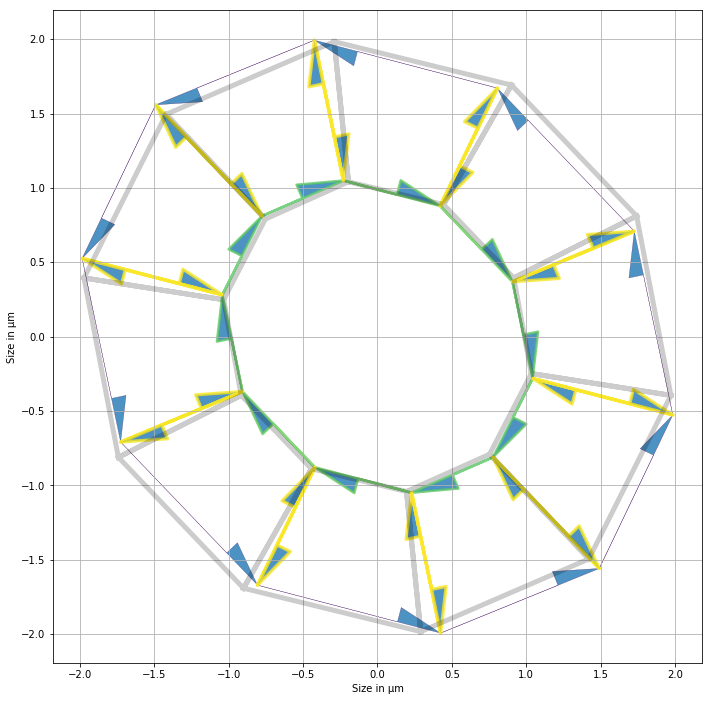

In [4]:
#Calling force inference
fi_init = infer_forces(organo, t_sum=opt_cst)
fi_t = fi_init['tensions']
fi_a = fi_init['areas']
organo_fi = organo.copy()
#Setting fi results in the mesh
organo_fi.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo_fi, fi_t)
organo_fi.face_df.loc[:, 'prefered_area'] = organo_fi.face_df.area + fi_a[:-1]
organo_fi.settings['lumen_prefered_vol'] = organo_fi.settings['lumen_volume'] + fi_a[-1]
#Solving for energy min and displaying
Solver.find_energy_min(organo_fi, geom, model)
print_tensions(organo_fi, organo)
print('\nDistance from th org to exp org: ', np.sum(_distance(organo_fi, organo)))